In [ ]:
from cobra.io import load_matlab_model
import pandas as pd
import numpy as np
from pytfa.io import load_thermoDB,                    \
                        read_lexicon, annotate_from_lexicon,            \
                        read_compartment_data, apply_compartment_data

root_dir = '../../pytfa/'

# Load the model
model = load_matlab_model(root_dir + 'models/small_ecoli.mat')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/joshuagoldford/opt/miniconda3/envs/coenzymes/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-5fb112a890dd>", line 1, in <module>
    from cobra.io import load_matlab_model
  File "/Users/joshuagoldford/opt/miniconda3/envs/coenzymes/lib/python3.8/site-packages/cobra/__init__.py", line 5, in <module>
    from cobra.core import (
  File "/Users/joshuagoldford/opt/miniconda3/envs/coenzymes/lib/python3.8/site-packages/cobra/core/__init__.py", line 1, in <module>
    from cobra.core.configuration import Configuration
  File "/Users/joshuagoldford/opt/miniconda3/envs/coenzymes/lib/python3.8/site-packages/cobra/core/configuration.py", line 15, in <module>
    from cobra.exceptions import SolverNotFound
  File "/Users/joshuagoldford/opt/miniconda3/envs/coenzymes/lib/python3.8/site-packages/cobra/exceptions.py", line 5, in <module>

TypeError: object of type 'NoneType' has no len()

In [2]:
model.reactions.get_by_id('None')

KeyError: 'None'

In [3]:
a = 'None'

In [41]:
import pytfa


In [5]:
a == "None"

True

In [4]:
def single_coenzyme_transform(model,reaction_id):
    met = {}
    met['nad'] = np.where([x.id == 'nad_c' for x in model.metabolites])[0][0]
    met['nadp'] = np.where([x.id == 'nadp_c' for x in model.metabolites])[0][0]
    met['nadh'] = np.where([x.id == 'nadh_c' for x in model.metabolites])[0][0]
    met['nadph'] = np.where([x.id == 'nadph_c' for x in model.metabolites])[0][0]

    met_objs = {}
    met_objs['nad'] = [x for x in model.metabolites if x.id == 'nad_c'][0]
    met_objs['nadh'] = [x for x in model.metabolites if x.id == 'nadh_c'][0]
    met_objs['nadp'] = [x for x in model.metabolites if x.id == 'nadp_c'][0]
    met_objs['nadph'] = [x for x in model.metabolites if x.id == 'nadph_c'][0]
    
    rxn = [x for x in model.reactions if x.id == reaction_id][0].copy()
    # make a new dictionary with coenzyme swapped
    v = {x:y for x,y in rxn.metabolites.items() if x.id in [x + '_c' for x in list(met)]}
    
    nad_stoich = 0;
    nadh_stoich  = 0;
    
    if len(v) > 0:
        v2 = {}
        for x,y in v.items():
            if x.id == 'nadph_c':
                nadh_stoich = nadh_stoich + y 
                #v2[met_objs['nadh']] = y
            elif x.id == 'nadp_c':
                nad_stoich = nad_stoich + y 
                #v2[met_objs['nad']] = y
            elif x.id == 'nadh_c':
                nadh_stoich = nadh_stoich + y 
                #v2[met_objs['nadph']] = y
            elif x.id == 'nad_c':
                nad_stoich = nad_stoich + y 
                #v2[met_objs['nadp']] = y

        v2[met_objs['nad']] = nad_stoich
        v2[met_objs['nadh']] = nadh_stoich

        rxn.subtract_metabolites(v)
        rxn.add_metabolites(v2)
        rxn.id = rxn.id + '[condensed]'
        model.remove_reactions([x for x in model.reactions if x.id == reaction_id][0])
        model.add_reaction(rxn)
        
    return model


m  = model.copy()
rxn_ids = [x.id for x in model.reactions]

for rxnid in rxn_ids:
    m = single_coenzyme_transform(m,rxnid)
    
m.remove_reactions([x for x in m.reactions if x.id == 'NADTRHD[condensed]'][0])
m.objective = 'Ec_biomass_iJO1366_WT_53p95M[condensed]'


/Users/joshuagoldford/opt/miniconda3/envs/coenzymes/lib/python3.8/site-packages/cobra/core/model.py:745: UserWarning: need to pass in a list
  warn("need to pass in a list")


In [5]:
essential = pd.read_csv('../assets/exchangeRxns.reducedModel.Essential.lowerBounds.31Jan2021.csv',index_col=0)
media_sets = pd.read_csv('../assets/reducedModel.mediaSets.31Jan2021.csv',index_col=0)

In [8]:
thermo_data = load_thermoDB(root_dir + 'data/thermo_data.thermodb')
lexicon = read_lexicon(root_dir + 'models/small_ecoli/lexicon.csv')
compartment_data = read_compartment_data(root_dir + 'models/small_ecoli/compartment_data.json')

In [31]:
cflux = model.reactions.get_by_id('DM_glc_e').lower_bound
eflux = model.reactions.get_by_id('DM_o2_e').lower_bound
sflux = model.reactions.get_by_id('DM_so4_e').lower_bound
pflux = model.reactions.get_by_id('DM_pi_e').lower_bound
nflux = model.reactions.get_by_id('DM_nh4_e').lower_bound

model.reactions.get_by_id('DM_glc_e').lower_bound = 0;
model.reactions.get_by_id('DM_o2_e').lower_bound = 0;
model.reactions.get_by_id('DM_so4_e').lower_bound = 0;
model.reactions.get_by_id('DM_pi_e').lower_bound = 0;
model.reactions.get_by_id('DM_nh4_e').lower_bound = 0;

In [33]:
model_base = model.copy()

In [ ]:
objective = []
for idx,row in media_sets.iterrows():
    mi = model_base.copy();
    mi.reactions.get_by_id(row.carbon).lower_bound = cflux*10;
    mi.reactions.get_by_id(row.nitrogen).lower_bound = nflux;
    mi.reactions.get_by_id(row.sulfur).lower_bound = sflux;
    mi.reactions.get_by_id(row.phosphorous).lower_bound = pflux;
    mi.reactions.get_by_id(row.electron).lower_bound = eflux;

    # Initialize the model
    tmodel = pytfa.ThermoModel(thermo_data, mi)
    tmodel.name = 'wt'

    # Annotate the model
    annotate_from_lexicon(tmodel, lexicon)
    apply_compartment_data(tmodel, compartment_data)

    ## TFA conversion
    tmodel.prepare()
    tmodel.convert()
    
    tfa_solution = tmodel.slim_optimize()
    objective.append(tfa_solution)

2021-01-31 20:55:44,053 - thermomodel_None - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2021-01-31 20:55:44,055 - thermomodel_None - INFO - # Model preparation starting...
2021-01-31 20:55:44,191 - thermomodel_None - WARNING - Warning : NULL/U
2021-01-31 20:55:44,191 - thermomodel_None - WARNING - Warning : NULL/L
2021-01-31 20:55:44,193 - thermomodel_None - WARNING - Warning : NULL/L
2021-01-31 20:55:44,197 - thermomodel_None - WARNING - Warning : NULL/U
2021-01-31 20:55:44,199 - thermomodel_None - WARNING - Warning : NULL/L
2021-01-31 20:55:44,202 - thermomodel_None - WARNING - Warning : NULL/L
2021-01-31 20:55:44,276 - thermomodel_None - WARNING - Warning : NULL/U
2021-01-31 20:55:44,277 - thermomodel_None - WARNING - Warning : NULL/L
2021-01-31 20:55:44,278 - thermomodel_None - WARNING - Warning : NULL/L
2021-01-31 20:55:44,280 - thermomodel_None - WARNING - Warning : NULL/U
2021-01-31 20:55:44,284 - thermomodel_None - WARNING - Warning : NULL/L
2021-01

In [9]:
gr = pd.read_csv('../scc/temp.tfba.01Feb2021.csv')

In [12]:
media_sets = pd.read_csv('../assets/reducedModel.mediaSets.31Jan2021.csv',index_col=0)

In [13]:
media_sets

,carbon,nitrogen,electron,sulfur,phosphorous
0,DM_5DRIB,DM_5DRIB,DM_o2_e,DM_5mtr_e,DM_pi_e
1,DM_5DRIB,DM_5DRIB,DM_o2_e,DM_5mtr_e,None
2,DM_5DRIB,DM_5DRIB,DM_o2_e,DM_cys-L_e,DM_pi_e
3,DM_5DRIB,DM_5DRIB,DM_o2_e,DM_cys-L_e,None
4,DM_5DRIB,DM_5DRIB,DM_o2_e,DM_gthrd_e,DM_pi_e
...,...,...,...,...,...
22355,None,None,None,DM_gthrd_e,None
22356,None,None,None,DM_so4_e,DM_pi_e
22357,None,None,None,DM_so4_e,None
22358,None,None,None,None,DM_pi_e


In [16]:
z = gr.join(media_sets)

In [20]:
z = z[z['wt'] > 0]

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

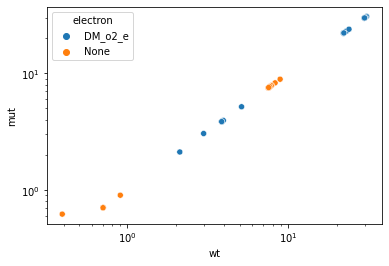

In [29]:
sns.scatterplot(x='wt',y='mut',data=z,hue='electron')
plt.xscale('log')
plt.yscale('log')

/Users/joshuagoldford/opt/miniconda3/envs/coenzymes/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

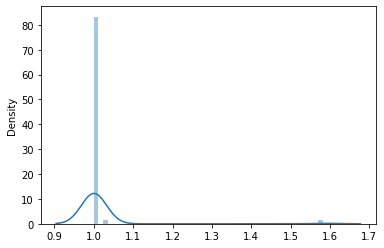

In [33]:
sns.distplot(z['mut'] / z['wt'])

In [42]:
m2 = media_sets[media_sets.sulfur.isin(['DM_so4_e']) & media_sets.phosphorous.isin(['DM_pi_e'])]

In [46]:
z['carbon'].unique()

array(['DM_5DRIB', 'DM_5mtr_e', 'DM_ac_e', 'DM_acald_e', 'DM_acser_e',
       'DM_akg_e', 'DM_ala-D_e', 'DM_ala-L_e', 'DM_alaala_e',
       'DM_arg-L_e', 'DM_asn-L_e', 'DM_asp-L_e'], dtype=object)

In [52]:
m2 = m2.reset_index().drop('index',axis=1)

In [54]:
m2.to_csv('../assets/reducedModel.mediaSets.2236.31Jan2021.csv')

In [55]:
m2

,carbon,nitrogen,electron,sulfur,phosphorous
0,DM_5DRIB,DM_5DRIB,DM_o2_e,DM_so4_e,DM_pi_e
1,DM_5DRIB,DM_5DRIB,None,DM_so4_e,DM_pi_e
2,DM_5DRIB,DM_5mtr_e,DM_o2_e,DM_so4_e,DM_pi_e
3,DM_5DRIB,DM_5mtr_e,None,DM_so4_e,DM_pi_e
4,DM_5DRIB,DM_acser_e,DM_o2_e,DM_so4_e,DM_pi_e
...,...,...,...,...,...
2231,None,DM_tyr-L_e,None,DM_so4_e,DM_pi_e
2232,None,DM_val-L_e,DM_o2_e,DM_so4_e,DM_pi_e
2233,None,DM_val-L_e,None,DM_so4_e,DM_pi_e
2234,None,None,DM_o2_e,DM_so4_e,DM_pi_e
